*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

## Training a logistic regression model

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

Read the data on social network ads. The data shows if the person purchased a product when targeted with an ad on social media. Fit a logistic regression model to predict if a user will purchase the product based on their characteristics such as age, gender and estimated salary.

In [7]:
train = pd.read_csv('./Datasets/Social_Network_Ads_train.csv') #Develop the model on train data
test = pd.read_csv('./Datasets/Social_Network_Ads_test.csv') #Test the model on test data

In [8]:
train.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15755018,Male,36,33000,0
1,15697020,Female,39,61000,0
2,15796351,Male,36,118000,1
3,15665760,Male,39,122000,1
4,15794661,Female,26,118000,0


Let us try to fit a linear regression model, instead of logistic regression. We fit a linear regression model to predict probability of purchase based on age.

<AxesSubplot:xlabel='Age', ylabel='Purchased'>

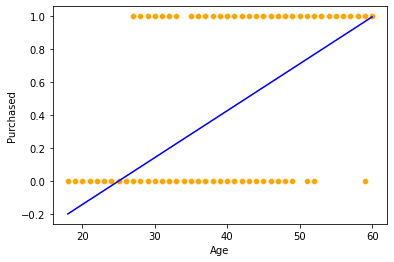

In [9]:
sns.scatterplot(x = 'Age', y = 'Purchased', data = train, color = 'orange') #Visualizing data
lm = sm.ols(formula = 'Purchased~Age', data = train).fit() #Developing linear regression model
sns.lineplot(x = 'Age', y= lm.predict(train), data = train, color = 'blue') #Visualizing model

Note the issues with the linear regression model:

1. The regression line goes below 0 and over 1. However, probability of purchase must be in \[0,1\]. 

2. The linear regression model does not seem to fit the data well.

Now, let us fit a logistic regression model to predict probability of purchase based on `Age`.

Optimization terminated successfully.
         Current function value: 0.430107
         Iterations 7


<AxesSubplot:xlabel='Age', ylabel='Purchased'>

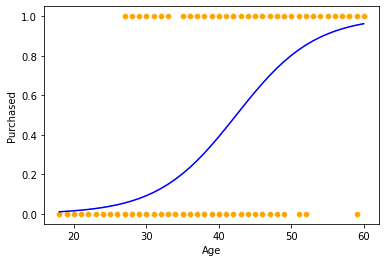

In [15]:
sns.scatterplot(x = 'Age', y = 'Purchased', data = train, color = 'orange') #Visualizing data
logit_model = sm.logit(formula = 'Purchased~Age', data = train).fit() #Developing logistic regression model
sns.lineplot(x = 'Age', y= logit_model.predict(train), data = train, color = 'blue') #Visualizing model

As logistic regression uses the sigmoid function, the probability stays in \[0,1\]. Also, it seems to better fit the points as compared to linear regression.

In [16]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Purchased   No. Observations:                  300
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Apr 2022   Pseudo R-squ.:                  0.3378
Time:                        16:46:02   Log-Likelihood:                -129.03
converged:                       True   LL-Null:                       -194.85
Covariance Type:            nonrobust   LLR p-value:                 1.805e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.8102      0.885     -8.825      0.000      -9.545      -6.076
Age            0.1842      0.022      8.449      0.000       0.141       0.227
==============================================================================
"""

**Interpret the coefficient of age** 

For a unit increase in age, the log odds of purchase increase by 0.18, or the odds of purchase get multiplied by exp(0.18) = 1.2

**Is the increase in probability of purchase constant with a unit increase in age?**

No, it depends on age.

**Is gender associated with probability of purchase?**

In [17]:
logit_model_gender = sm.logit(formula = 'Purchased~Gender', data = train).fit()
logit_model_gender.summary()

Optimization terminated successfully.
         Current function value: 0.648804
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Purchased   No. Observations:                  300
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            1
Date:                Tue, 19 Apr 2022   Pseudo R-squ.:                0.001049
Time:                        16:46:04   Log-Likelihood:                -194.64
converged:                       True   LL-Null:                       -194.85
Covariance Type:            nonrobust   LLR p-value:                    0.5225
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5285      0.168     -3.137      0.002      -0.859      -0.198
Gender[T.Male]    -0.1546      0.242     -0.639      0.523      -0.629       0.319
==================================================================================
"""

No, assuming a significance level of $\alpha = 5\%$, `Gender` is not associated with probability of default, as the $p$-value for `Male` is greater than 0.05.

## Confusion matrix and prediction accuracy

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. 

*[Source](https://machinelearningmastery.com/confusion-matrix-machine-learning/#:~:text=A%20confusion%20matrix%20is%20a%20summary%20of%20prediction%20results%20on,key%20to%20the%20confusion%20matrix)*

In [18]:
#Function to compute confusion matrix and prediction accuracy on training data
def confusion_matrix_train(model,cutoff=0.5):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    return cm_df, accuracy

Find the confusion matrix and classification accuracy of the model with `Age` as the predictor on training data.

In [19]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        181.0         13.0
 Actual 1         37.0         69.0,
 83.33333333333333)

In [20]:
#Function to compute confusion matrix and prediction accuracy on test data
def confusion_matrix_test(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
# Return the confusion matrix and the accuracy
    return cm_df, accuracy

Find the confusion matrix and classification accuracy of the model with `Age` as the predictor on test data.

In [21]:
confusion_matrix_test(test,test.Purchased,logit_model)

(          Predicted 0  Predicted 1
 Actual 0         58.0          5.0
 Actual 1          9.0         28.0,
 86.0)

The model classifies a bit more accurately on test data as compared to the training data, which is a bit unusual. However, it shows that the model did not overfit on training data.

**Include EstimatedSalary as a predictor in the above model**

In [22]:
logit_model2 = sm.logit(formula = 'Purchased~Age+EstimatedSalary', data = train).fit()
logit_model2.summary()

Optimization terminated successfully.
         Current function value: 0.358910
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Purchased   No. Observations:                  300
Model:                          Logit   Df Residuals:                      297
Method:                           MLE   Df Model:                            2
Date:                Tue, 19 Apr 2022   Pseudo R-squ.:                  0.4474
Time:                        16:46:11   Log-Likelihood:                -107.67
converged:                       True   LL-Null:                       -194.85
Covariance Type:            nonrobust   LLR p-value:                 1.385e-38
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.9432      1.424     -8.386      0.000     -14.735      -9.152
Age                 0.2242      0.028      7.890      0.000       0.168       0.280
EstimatedSalary   3.48e-05   6.15e-06      5.660      0.000    2.27e-05    4.68e-05
===================================================================================
"""

In [23]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        181.0         13.0
 Actual 1         37.0         69.0,
 83.33333333333333)

In [24]:
confusion_matrix_test(test,test.Purchased,logit_model)

(          Predicted 0  Predicted 1
 Actual 0         58.0          5.0
 Actual 1          9.0         28.0,
 86.0)

The log likelihood of the model has increased, while also increasing the prediction accuracy on test data, which shows that the additional predictor is helping explain the response better, without overfitting the data.

**Include Gender as a predictor in the above model**

In [25]:
logit_model = sm.logit(formula = 'Purchased~Age+EstimatedSalary+Gender', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.357327
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Purchased   No. Observations:                  300
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            3
Date:                Tue, 19 Apr 2022   Pseudo R-squ.:                  0.4498
Time:                        16:46:13   Log-Likelihood:                -107.20
converged:                       True   LL-Null:                       -194.85
Covariance Type:            nonrobust   LLR p-value:                 9.150e-38
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -12.2531      1.478     -8.293      0.000     -15.149      -9.357
Gender[T.Male]      0.3356      0.346      0.970      0.332      -0.342       1.013
Age                 0.2275      0.029      7.888      0.000       0.171       0.284
EstimatedSalary  3.494e-05   6.17e-06      5.666      0.000    2.29e-05     4.7e-05
===================================================================================
"""

In [26]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        180.0         14.0
 Actual 1         33.0         73.0,
 84.33333333333333)

In [27]:
confusion_matrix_test(test,test.Purchased,logit_model)

(          Predicted 0  Predicted 1
 Actual 0         57.0          6.0
 Actual 1          6.0         31.0,
 88.0)

As Gender is an insignificant variable, including it slightly lowers the classification accuracy on test data. Note that the classification accuracy on training data will continue to increase on adding more predictors, irrespective of their relevance.

**Is there a residual in logistic regression?**

No, since the response is assumed to have a Bernoulli distribution, instead of a normal distribution.

**Is the odds ratio for a unit increase in a predictor $X_j$, a constant (assuming that the rest of the predictors are held constant)?**

Yes, the odds ratio in this case will $e^{\beta_j}$

## Variable tranformations in logistic regression

Read the dataset *diabetes.csv* that contains if a person has diabetes (*Outcome = 1*) based on health parameters such as BMI, blood pressure, age etc. Develop a model to predict the probability of a person having diabetes based on their age.

In [2]:
data = pd.read_csv('diabetes.csv')

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Randomly select 80% of the observations to create a training dataset. Create a test dataset with the remaining 20% observations.

In [4]:
#Creating training and test datasets
np.random.seed(2)
train = data.sample(round(data.shape[0]*0.8))
test = data.drop(train.index)

Does `Age` seem to distinguish *Outcome's*?

<AxesSubplot:xlabel='Outcome', ylabel='Age'>

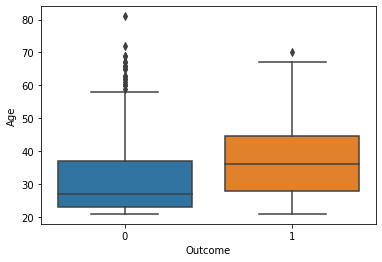

In [80]:
sns.boxplot(x = 'Outcome', y = 'Age', data = train)

Yes it does!

Develop and visualize a logistic regression model to predict `Outcome` using `Age`.

Optimization terminated successfully.
         Current function value: 0.612356
         Iterations 5
-375.9863802089716


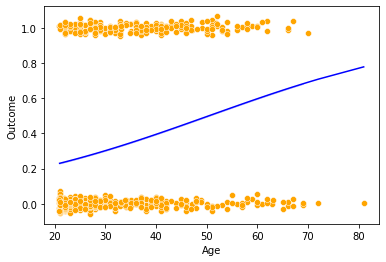

In [81]:
#Jittering points to better see the density of points in any given region of the plot
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(train.Age,0), y = jitter(train.Outcome,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'Outcome~Age', data = train).fit()
sns.lineplot(x = 'Age', y= logit_model.predict(train), data = train, color = 'blue') 
print(logit_model.llf) #Printing the log likelihood to compare it with the next model we build

In [82]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        372.0         35.0
 Actual 1        176.0         31.0,
 65.63517915309447)

Classification accuracy on train data = 66%

In [83]:
confusion_matrix_test(test,test.Outcome,logit_model)

(          Predicted 0  Predicted 1
 Actual 0         85.0          8.0
 Actual 1         54.0          7.0,
 59.74025974025974)

Classification accuracy on test data = 60%

Can a tranformation of `Age` provide a more accurate model?

Let us visualize how the probability of people having diabetes varies with `Age`. We will bin `Age` to get the percentage of people having diabetes within different `Age` bins.

In [84]:
#Binning Age
binned_age = pd.qcut(train['Age'],11,retbins=True)
train['age_binned'] = binned_age[0]

In [85]:
#Finding percentage of people having diabetes in each Age bin
age_data = train.groupby('age_binned')['Outcome'].agg([('diabetes_percent','mean'),('nobs','count')]).reset_index(drop=False)
age_data

,age_binned,diabetes_percent,nobs
0,"(20.999, 22.0]",0.110092,109
1,"(22.0, 23.0]",0.206897,29
2,"(23.0, 25.0]",0.243243,74
3,"(25.0, 26.0]",0.259259,27
4,"(26.0, 28.0]",0.271186,59
5,"(28.0, 31.0]",0.415094,53
6,"(31.0, 35.0]",0.434783,46
7,"(35.0, 39.0]",0.450980,51
8,"(39.0, 43.545]",0.500000,54
9,"(43.545, 52.0]",0.576271,59


Text(0.5, 0, 'Age_bin')

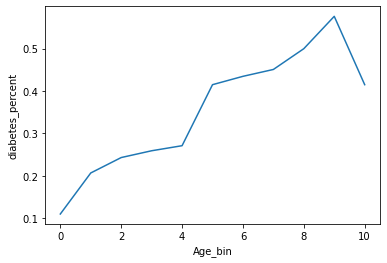

In [86]:
#Visualizing percentage of people having diabets with increasing Age (or Age bins)
sns.lineplot(x = age_data.index, y= age_data['diabetes_percent'])
plt.xlabel('Age_bin')

We observe that the probability of people having diabetes does **not** keep increaseing monotonically with age. People with ages 52 and more have a lower probability of having diabetes than people in the immediately younger `Age` bin.

A quadratic transformation of `Age` may better fit the above trend

Optimization terminated successfully.
         Current function value: 0.586025
         Iterations 6


-359.81925590230185

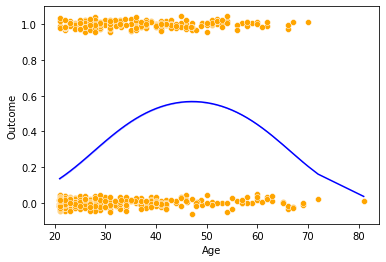

In [87]:
#Model with the quadratic transformation of Age
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(train.Age,0), y = jitter(train.Outcome,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'Outcome~Age+I(Age**2)', data = train).fit()
sns.lineplot(x = 'Age', y= logit_model.predict(train), data = train, color = 'blue') 
logit_model.llf

In [88]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  614
Model:                          Logit   Df Residuals:                      611
Method:                           MLE   Df Model:                            2
Date:                Wed, 20 Apr 2022   Pseudo R-squ.:                 0.08307
Time:                        01:13:43   Log-Likelihood:                -359.82
converged:                       True   LL-Null:                       -392.42
Covariance Type:            nonrobust   LLR p-value:                 6.965e-15
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -6.6485      0.908     -7.320      0.000      -8.429      -4.868
Age             0.2936      0.048      6.101      0.000       0.199       0.388
I(Age ** 2)    -0.0031      0.001     -5.280      0.000      -0.004      -0.002
===============================================================================
"""

The log likelihood of the model is higher and both the predictors are statistically significant indicating a better model fit. However, the model may also be overfitting. Let us check the model accuracy on test data.

In [89]:
confusion_matrix_train(logit_model)

(          Predicted 0  Predicted 1
 Actual 0        338.0         69.0
 Actual 1        127.0         80.0,
 68.07817589576547)

In [90]:
confusion_matrix_test(test,test.Outcome,logit_model)

(          Predicted 0  Predicted 1
 Actual 0         80.0         13.0
 Actual 1         35.0         26.0,
 68.83116883116882)

The classification accuracy on test data has increased to 69%. However, the number of *false positives* have increased. But in case of diabetes, *false negatives* are more concerning that *false positives*. This is because if a person has diabetes, and is told that they do not have diabetes, their condition may deteriorate. If a person does not have diabetes, and is told that they have diabetes, they may take unnecessary precautions or tests, but it will not be as harmful to the person as in the previous case. So, in this problem, we will be more focused on reducing the number of *false negatives*, instead of reducing the *false positives* or increasing the overall classification accuracy.

We can decrease the cutoff for classifying a person as having diabetes to reduce the number of false negatives.

In [91]:
#Reducing the cutoff for classifying a person as diabetic to 0.3 (instead of 0.5)
confusion_matrix_test(test,test.Outcome,logit_model,0.3)

(          Predicted 0  Predicted 1
 Actual 0         58.0         35.0
 Actual 1         12.0         49.0,
 69.48051948051948)

Note that the changed cut-off reduced the number of *false negatives*, but at the cost of increasing the *false positives*. However, the stakeholders may prefer the reduced cut-off to be safer.

**Is there another way to transform `Age`?**

Yes, binning age into bins that have similar proportion of people with diabetes may provide a better model fit.

In [92]:
#Creating a function to bin age so that it can be applied to both the test and train datasets
def var_transform(data):
    binned_age = pd.qcut(train['Age'],10,retbins=True)
    bins = binned_age[1]
    data['age_binned'] = pd.cut(data['Age'],bins = bins)
    dum = pd.get_dummies(data.age_binned,drop_first = True)
    dum.columns = ['age'+str(x) for x in range(1,len(bins)-1)]
    data = pd.concat([data,dum], axis = 1)
    return data

In [93]:
#Binning age using the function var_transform()
train = var_transform(train)
test = var_transform(test)

Text(0.5, 0, 'Age_bin')

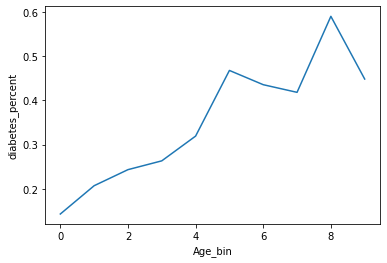

In [94]:
#Re-creating the plot of diabetes_percent vs age created earlier, just to check if the function binned age correctly. Yes, it did.
age_data = train.groupby('age_binned')['Outcome'].agg([('diabetes_percent','mean'),('nobs','count')]).reset_index(drop=False)
sns.lineplot(x = age_data.index, y= age_data['diabetes_percent'])
plt.xlabel('Age_bin')

Optimization terminated successfully.
         Current function value: 0.585956
         Iterations 6


<AxesSubplot:xlabel='Age', ylabel='Outcome'>

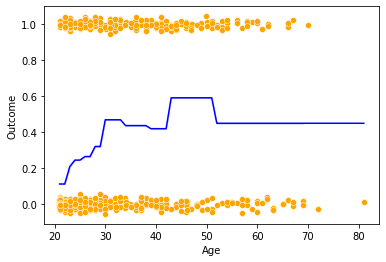

In [95]:
#Model with binned Age
def jitter(values,j):
    return values + np.random.normal(j,0.02,values.shape)
sns.scatterplot(x = jitter(train.Age,0), y = jitter(train.Outcome,0), data = train, color = 'orange')
logit_model = sm.logit(formula = 'Outcome~' + '+'.join(['age'+str(x) for x in range(1,10)]), data = train).fit()
sns.lineplot(x = 'Age', y= logit_model.predict(train), data = train, color = 'blue') 

Note that the probability of having diabetes for each age bin is a constant, as per the above plot.

In [96]:
confusion_matrix_test(test,test.Outcome,logit_model,0.3)

(          Predicted 0  Predicted 1
 Actual 0         53.0         40.0
 Actual 1         10.0         51.0,
 67.53246753246754)

Binning `Age` provides a similar results as compared to the model with the quadratic transformation of `Age`.

In [97]:
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_binned,age1,age2,age3,age4,age5,age6,age7,age8,age9
158,2,88,74,19,53,29.0,0.229,22,0,"(21.0, 22.0]",0,0,0,0,0,0,0,0,0
251,2,129,84,0,0,28.0,0.284,27,0,"(25.0, 27.0]",0,0,1,0,0,0,0,0,0
631,0,102,78,40,90,34.5,0.238,24,0,"(23.0, 25.0]",0,1,0,0,0,0,0,0,0
757,0,123,72,0,0,36.3,0.258,52,1,"(51.0, 81.0]",0,0,0,0,0,0,0,0,1
689,1,144,82,46,180,46.1,0.335,46,1,"(42.0, 51.0]",0,0,0,0,0,0,0,1,0


In [6]:
#Model with the quadratic transformation of Age and more predictors
logit_model = sm.logit(formula = 'Outcome~Age+I(Age**2)+Glucose+BloodPressure+BMI+DiabetesPedigreeFunction', data = train).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.470478
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  614
Model:                          Logit   Df Residuals:                      607
Method:                           MLE   Df Model:                            6
Date:                Mon, 25 Apr 2022   Pseudo R-squ.:                  0.2639
Time:                        11:26:50   Log-Likelihood:                -288.87
converged:                       True   LL-Null:                       -392.42
Covariance Type:            nonrobust   LLR p-value:                 5.878e-42
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -12.3347      1.282     -9.621      0.000     -14.847      -9.822
Age                          0.2852      0.056      5.121      0.000       0.176       0.394
I(Age ** 2)                 -0.0030      0.001     -4.453      0.000      -0.004      -0.002
Glucose                      0.0309      0.004      8.199      0.000       0.024       0.038
BloodPressure               -0.0141      0.006     -2.426      0.015      -0.025      -0.003
BMI                          0.0800      0.016      4.978      0.000       0.049       0.112
DiabetesPedigreeFunction     0.7138      0.322      2.213      0.027       0.082       1.346
============================================================================================
"""

Adding more predictors has increased the log likelihood of the model as expected.

In [7]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = 100*(cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("FNR = ", fnr)
    print("FPR = ", fpr)
    print("TPR or Recall = ", tpr)
    print("Confusion matrix = \n", cm_df)
    return (" ")

In [8]:
confusion_matrix_data(train,train.Outcome,logit_model, cutoff = 0.3)

Accuracy =  74.2671009771987
Precision =  58.78136200716846
FNR =  20.77294685990338
FPR =  28.255528255528255
TPR or Recall =  79.22705314009661
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0        292.0        115.0
Actual 1         43.0        164.0


' '

In [9]:
confusion_matrix_data(test,test.Outcome,logit_model,0.3)

Accuracy =  80.51948051948052
Precision =  70.12987012987013
FNR =  11.475409836065573
FPR =  24.731182795698924
TPR or Recall =  88.52459016393442
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0         70.0         23.0
Actual 1          7.0         54.0


' '

The model with more predictors also has lesser number of *false negatives*, and higher overall classification accuracy.

**How many bins must you make for `Age` to get the most accurate model?** \
If the number of bins are too less, the trend may not be captured accurately. If the number of bins are too many, it may lead to overfitting of the model. There is an optimal value of the number of bins that captures the trend, but does not overfit. A couple of ways of estimating the optimal number of bins can be:

1.  The number of bins for which the trend continues to be "almost" the same for several samples of the data. 

2. Testing the model on multiple test datasets.

Optimizing the number of bins for each predictor may be a time-consuming exercises. You may choose to do it for your course project. However, we wil not do in the rest of the course.

**Visualize the ROC curve and compute the ROC-AUC for the developed classification model**

0.8325914847653979


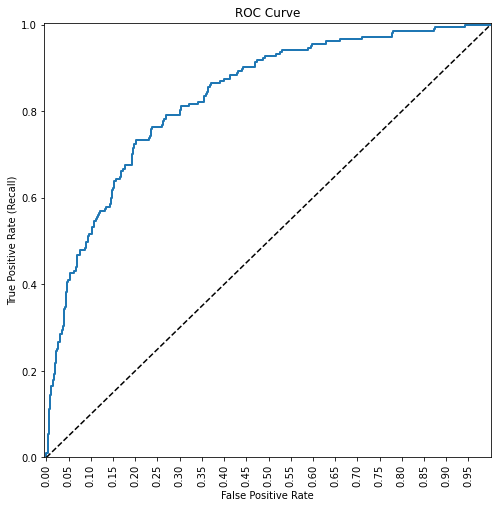

In [64]:
from sklearn.metrics import roc_curve, auc
y=train.Outcome
ypred = logit_model.predict(train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):

    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)